# New try to get the right decomposition

In [247]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import decomp_alllevels as deco
from imp import reload
import write_netCDF as write
import amoc_plots as aplot
import tools
import xz_tools as xz_tools
import numpy.ma as ma
import os
from scipy.interpolate import interp1d

In [248]:
case="11N"

if case=="10S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_10S-18S/aa"
    os.chdir(path)

if case=="11N":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_11N-18N/aa"
    os.chdir(path)

In [249]:
uko = tools.netread_data('../uko_p_stripe.nc','uko') # uko
wo_p = tools.netread_data('../wo_p_stripe.nc','wo') # wo at p-point
vke = tools.netread_data('../vke_p_stripe.nc','vke') # vke
nx = tools.netread_data('../dxN_vel_hor_mag_stripe.nc','dx_vel_hor_mag') # normal vector x-comp
ny = tools.netread_data('../dyN_vel_hor_mag_stripe.nc','dy_vel_hor_mag') # normal vector y-comp

rho = tools.netread_data('../rhopoto_stripe.nc','rhopoto') # density
lat,lon,depth = tools.netread_grid('../rhopoto_stripe.nc','lat','lon','depth_2')

In [250]:
ztop=800.
zbot=3800.

tmp1 = min(depth[:], key=lambda x:abs(x-ztop))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
ktop = tmp[0]
tmp1 = min(depth[:], key=lambda x:abs(x-zbot))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
kbot = tmp[0]
tmp1 = min(depth[:], key=lambda x:abs(x-2000.))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
k2k = tmp[0]

if case == "11N":
    lx=200 # for average 11N - 18N
    rx=350 # for average
    llon=210 # for plot
    rlon=237 # for plot
if case == "10S":
    lx=380 # for average 10S - 18S
    rx=600 # for average
    llon=472 # for plot
    rlon=500 # for plot

lat2 = lat[:,lx:rx]
lon2 = lon[:,lx:rx]
uko2 = uko[:,:,lx:rx]
vke2 = vke[:,:,lx:rx]
wo_p2 = wo_p[:,:,lx:rx]
rho2 = rho[:,:,lx:rx]
nx2 = 1*nx[:,:,lx:rx]
ny2 = 1*ny[:,:,lx:rx]

llon2 = llon-lx
rlon2 = llon-lx + (rlon -llon)

dist = np.zeros((lon[0,llon:rlon].shape))
for i in range(len(dist)):
    dist[i] = i * 11.113

x,z = np.meshgrid(dist,depth[ktop:kbot])

In [251]:
clines2 = np.zeros((kbot-ktop,uko.shape[1]))

maxpos = np.zeros((vke2.shape[1]))
tmp = vke2**2+uko2**2
for j in range(vke2.shape[1]):
        tmp1 = tmp[k2k,j,:].max()
        tmp2 = np.where(tmp[k2k,j,:]==tmp1)[0]
        maxpos[j] = tmp2[0]

for k in range(0,kbot-ktop):
    clines2[k,:] = maxpos[:]


/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:


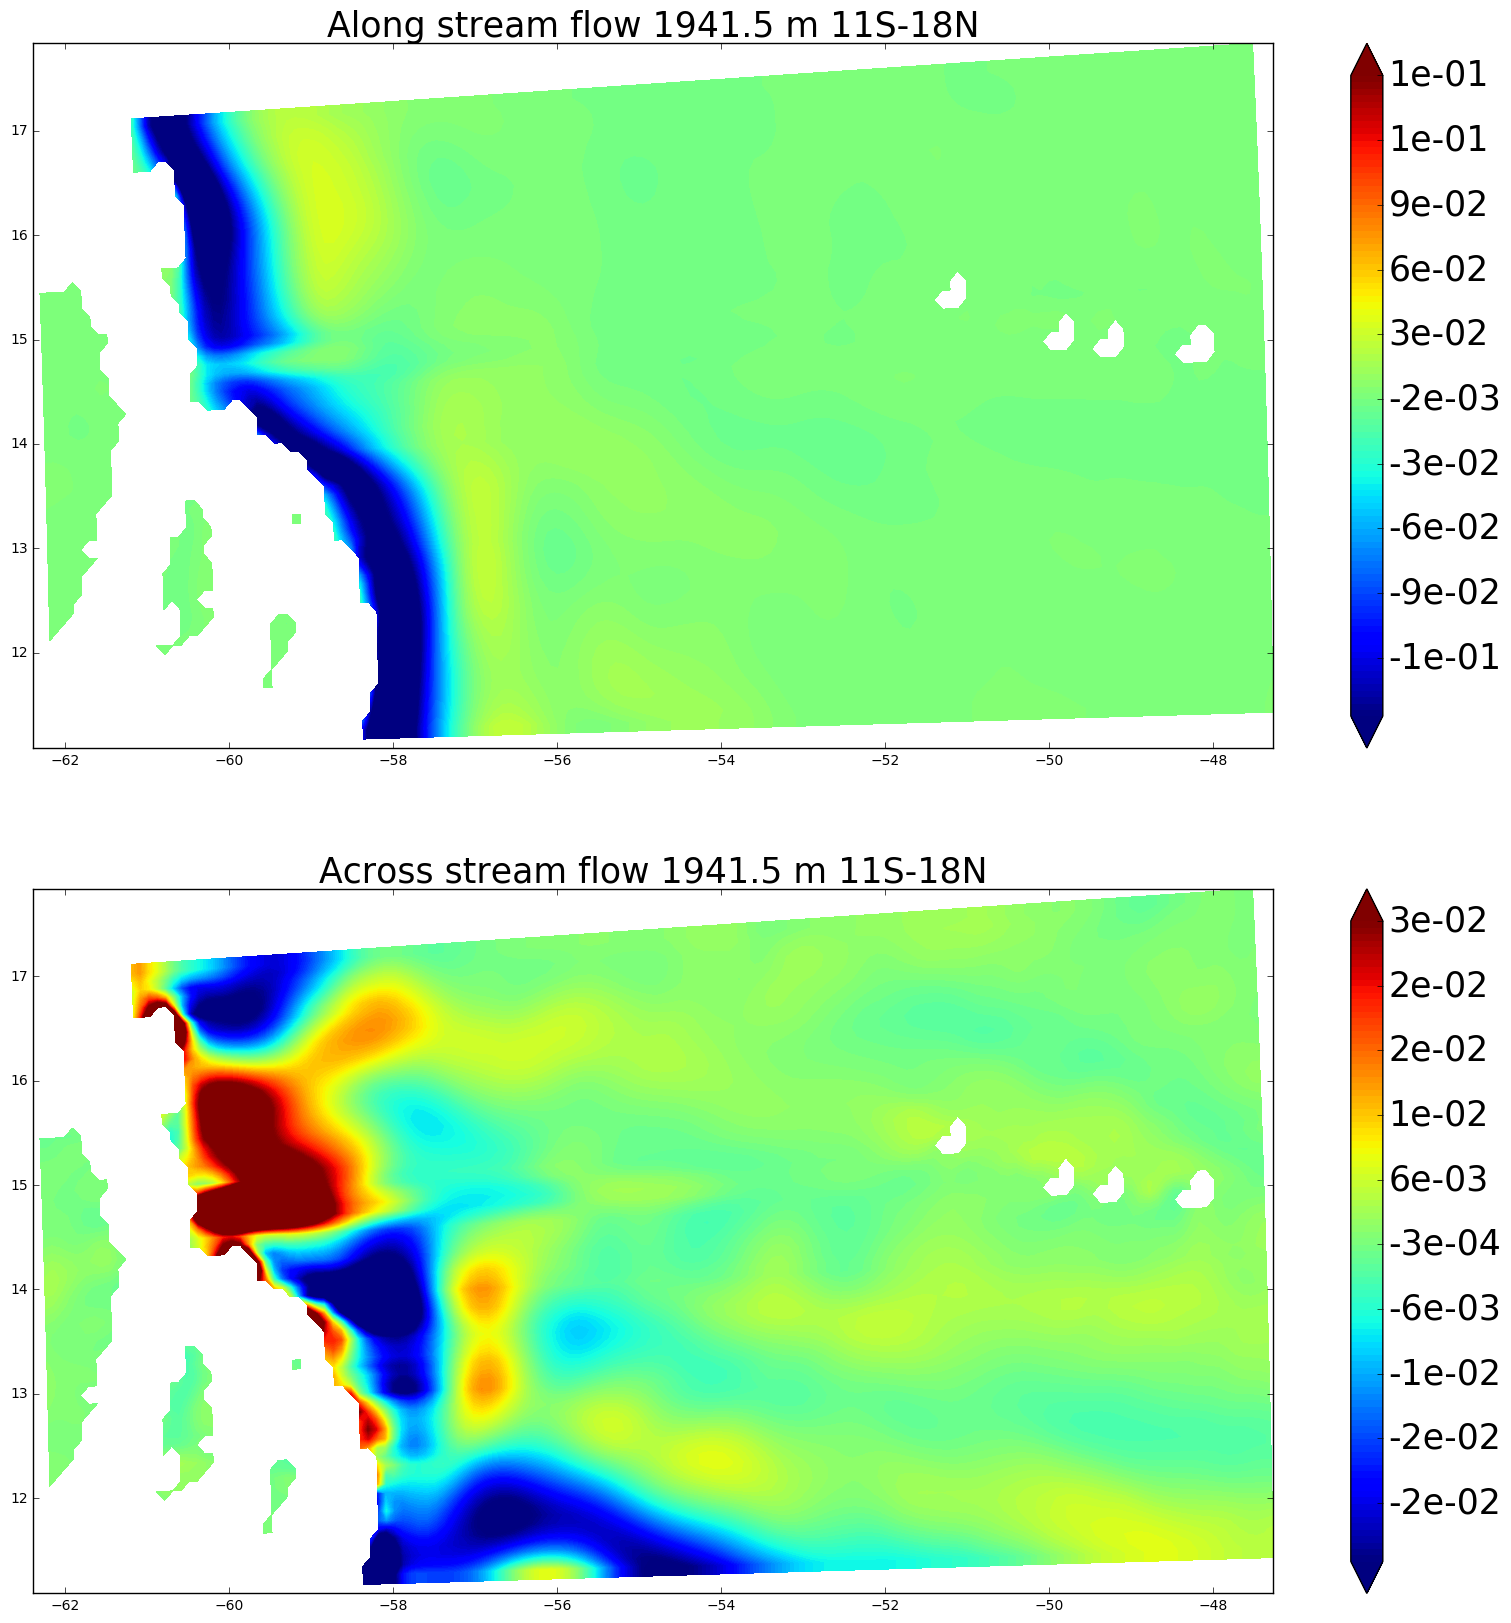

In [252]:
reload(deco)
normal, tangent = deco.read_normal_get_tangent(nx2,ny2,clines2,k2k)
upar,uper = deco.decomposition(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)

plt.figure(figsize=(20,20))
v = np.linspace(-0.15,0.15,100)
plt.subplot(211)
if case == "10S":
    plt.title("Along stream flow 1941.5 m 10S-18S",fontsize=25)
if case == "11N":
    plt.title("Along stream flow 1941.5 m 11S-18N",fontsize=25)
plt.contourf(lon2,lat2,upar[55,:,:],v,extend="both")
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
#plt.plot(clines_lon[44,:],clines_lat[44,:])
plt.subplot(212)
if case == "10S":
    plt.title("Across stream flow 1941.5 m 10S-18S",fontsize=25)
if case == "11N":
    plt.title("Across stream flow 1941.5 m 11S-18N",fontsize=25)
v1 = np.linspace(-0.03,0.03,100)
plt.contourf(lon2,lat2,uper[55,:,:],v1,extend="both")
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25)
#plt.plot(clines_lon[44,:],clines_lat[44,:])
#if case == "10S":
#    plt.savefig("xy-along_across_meanflow_10S-18S.png")
#if case == "11N":
#    plt.savefig("xy-along_across_meanflow_11N-18N.png")
plt.show()

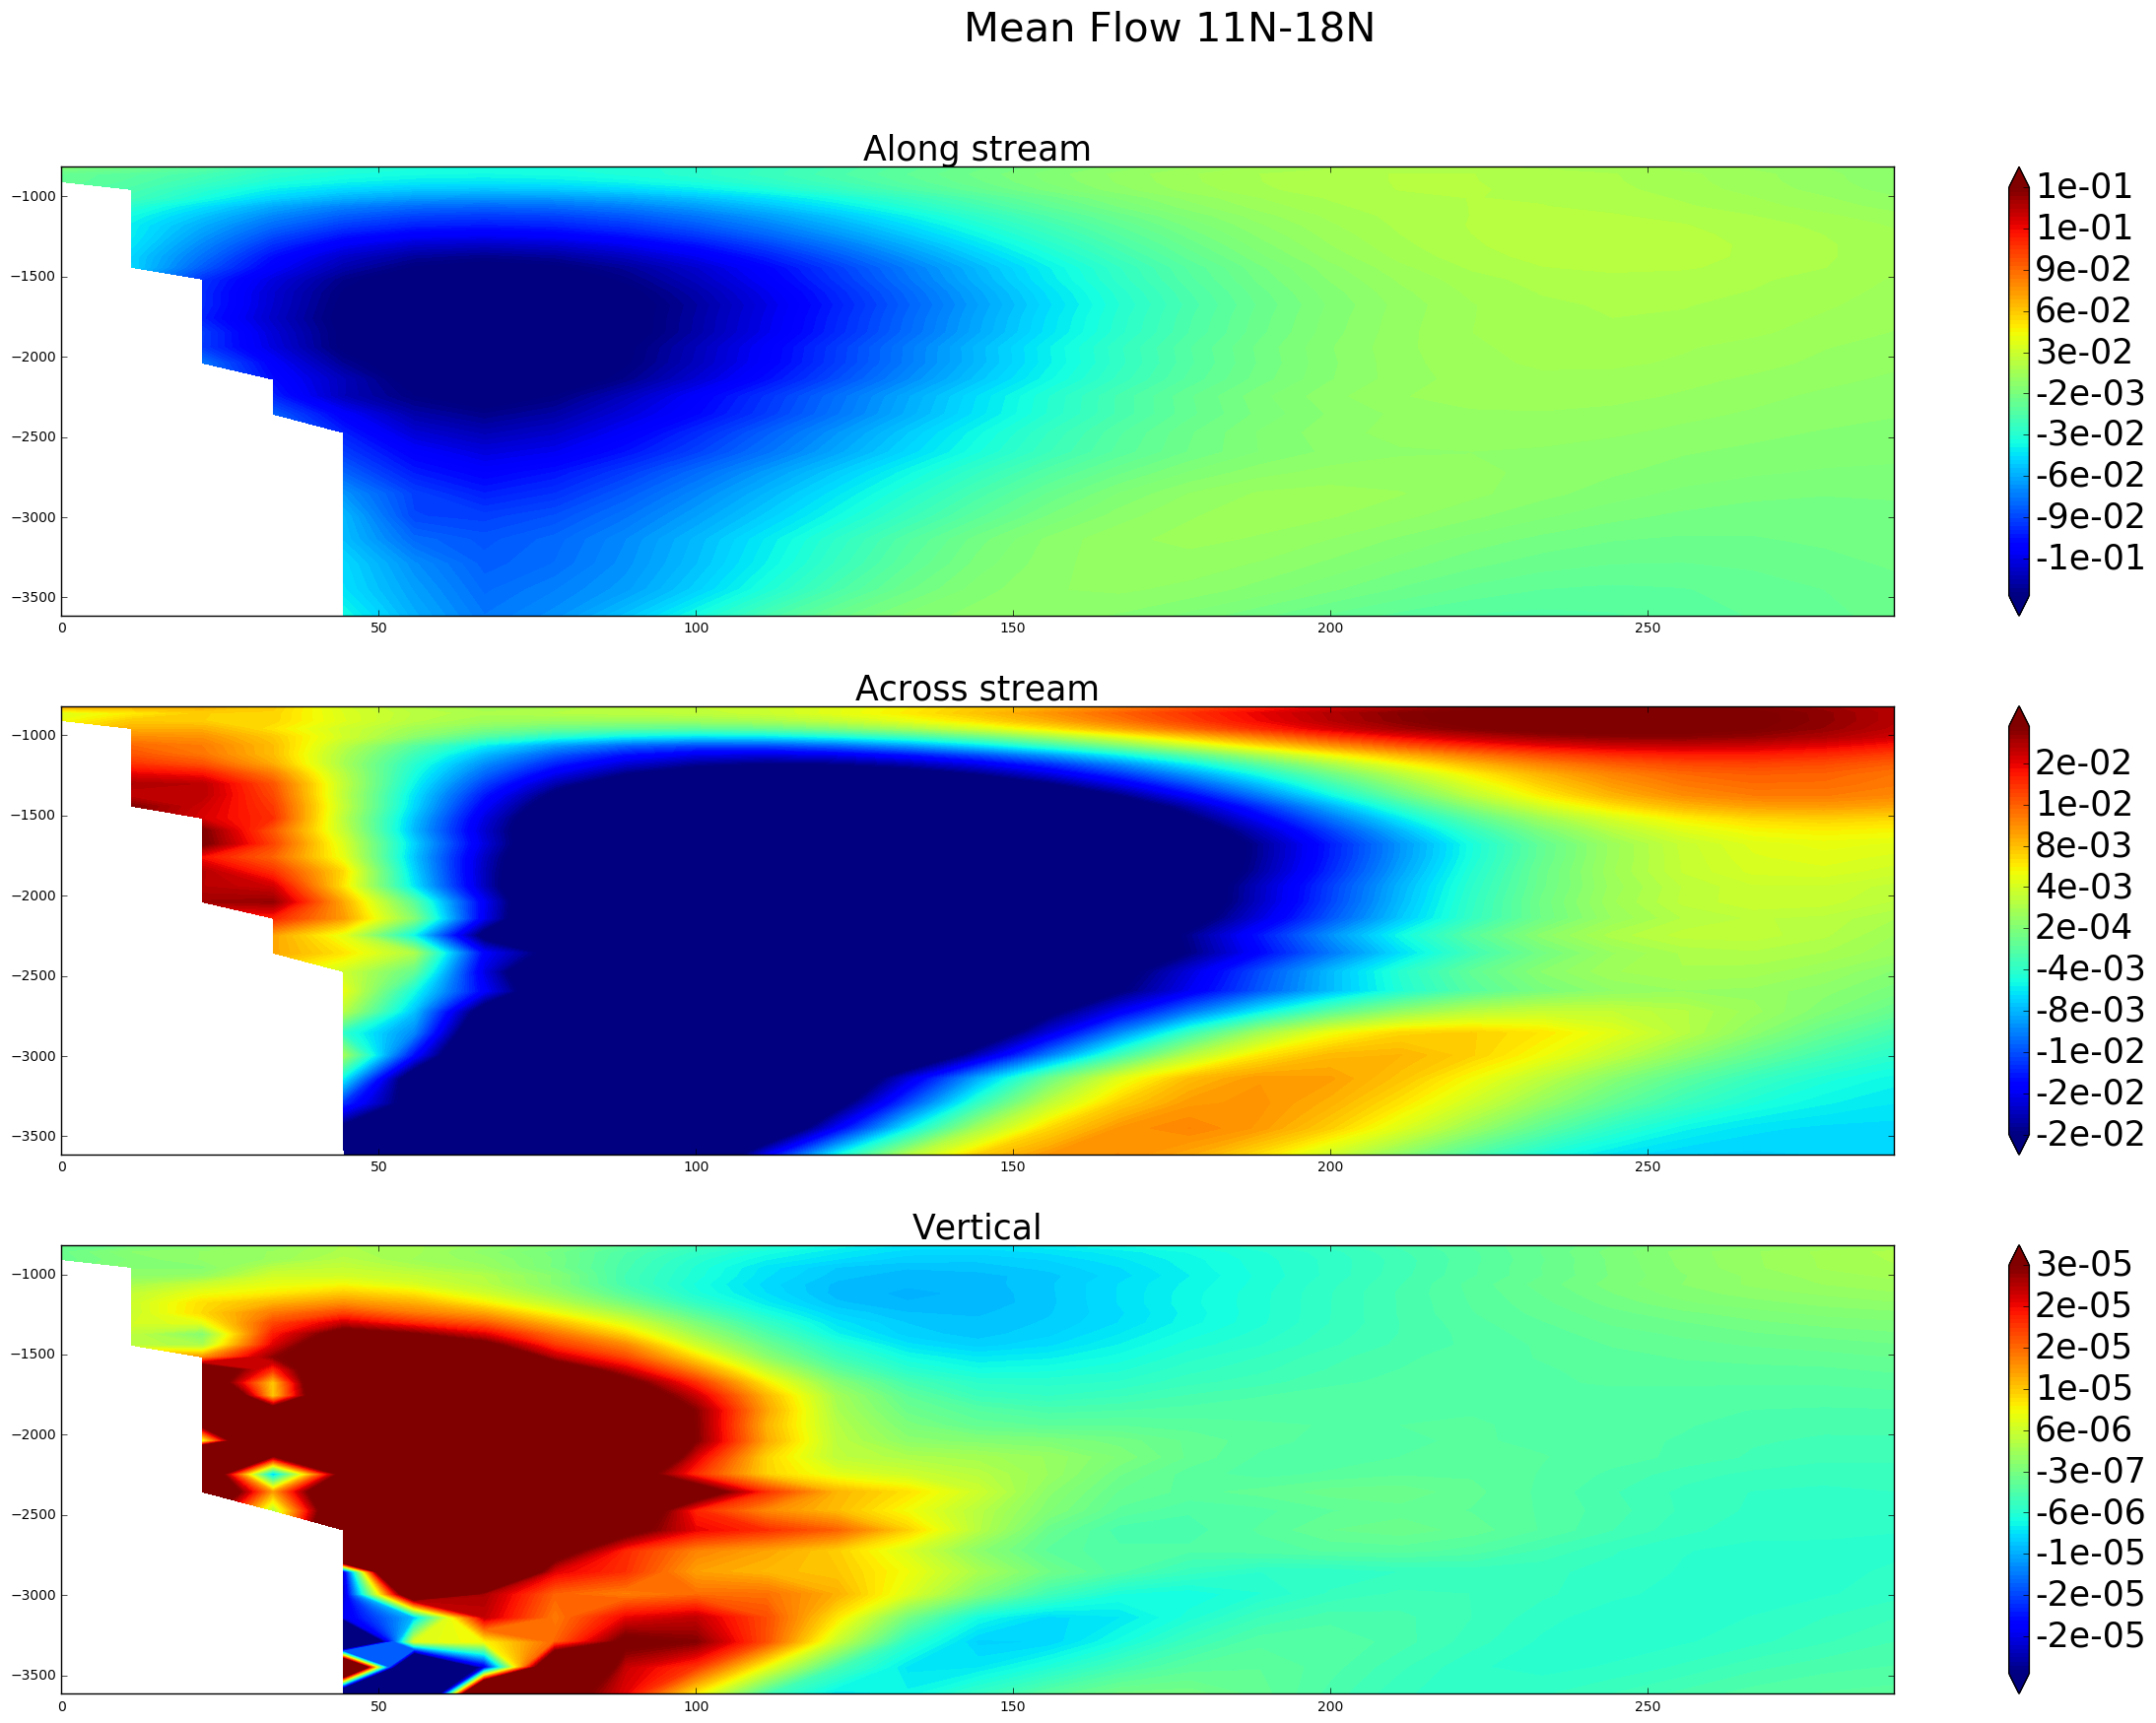

In [257]:
lat_from=14.
lat_to = 13.

reload(xz_tools)
mean_upar,data_upar = xz_tools.along_average(upar,upar,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_uper,data_uper = xz_tools.along_average(upar,uper,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_wo_p,data_wo_p = xz_tools.along_average(upar,wo_p2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)

plt.figure(figsize=(30,20))
if case == "10S":
    plt.suptitle("Mean Flow 10S-18S",fontsize=30)
if case == "11N":
    plt.suptitle("Mean Flow 11N-18N",fontsize=30)

plt.subplot(311)
v = np.linspace(-0.15,0.15,100)
plt.contourf(x,-z,data_upar[:,:],v,extend="both")
plt.title("Along stream",fontsize=25)
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
plt.subplot(312)
v = np.linspace(-0.02,0.02,100)
plt.contourf(x,-z,data_uper[:,:],v,extend="both")
plt.title("Across stream",fontsize=25)
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
plt.subplot(313)
v = np.linspace(-0.00003,0.00003,100)
plt.title("Vertical",fontsize=25)
plt.contourf(x,-z,data_wo_p[:,:],v,extend="both")
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
#if case == "10S":
#    plt.savefig("mean_flow_xz_10S-18S.png")
#if case == "11N":
#    plt.savefig("mean_flow_xz_11N-18N.png")
plt.show()

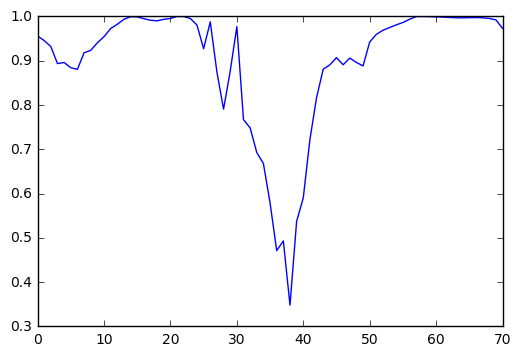

In [254]:
plt.plot(normal[56,:,1])
plt.show()